# Named Entity Recognition - CRF

Conditional random fields (CRFs) adalah kelas metode pemodelan statistik yang sering diterapkan dalam pengenalan pola dan machine learning dan digunakan untuk prediksi terstruktur. Sedangkan classifier memprediksi label untuk sampel tunggal tanpa mempertimbangkan sampel "neighboring", CRF dapat mempertimbangkan konteks. Untuk melakukannya, prediksi dimodelkan sebagai model grafis, yang mengimplementasikan dependensi antara prediksi.

In [1]:
import math
import warnings

import pyprind

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.exceptions import UndefinedMetricWarning

from model_plots import plot_learning_curve

## Load dataset menggunakan Pandas

In [2]:
# Read dataset dengan spasi sebagai separator ,keep blank line dan tambah columns
ner_data_train = pd.read_csv("./data/conll2003/train.txt", sep=" ", header=None, skip_blank_lines=False, encoding="utf-8")
ner_data_test = pd.read_csv("./data/conll2003/test.txt", sep=" ", header=None, skip_blank_lines=False, encoding="utf-8")
ner_data_train.columns = ["token", "pos", "chunk", "ne"]
ner_data_test.columns = ["token", "pos", "chunk", "ne"]

# Ekstrak data NE dan mengitung jumlahnya
tag_distribution = ner_data_train.groupby("ne").size().reset_index(name='counts')
print(tag_distribution)

# Ekstrak class yg memiliki informasi, bukan O, dan menjadikannya list
classes = list(filter(lambda x: x not in ["O", np.nan], list(ner_data_train["ne"].unique())))

print(classes)

       ne  counts
0   B-LOC    7140
1  B-MISC    3438
2   B-ORG    6321
3   B-PER    6600
4   I-LOC    1157
5  I-MISC    1155
6   I-ORG    3704
7   I-PER    4528
8       O  168346
['B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']


In [6]:
# Mengelompokkan setiap kalimat
sentences_train, sentence_train = [], []
# progress bar
pbar_train = pyprind.ProgBar(len(ner_data_train))
# For each row in the NER data train...
for index, row in ner_data_train.iterrows():
    # If the row is empty (no string in the token column)
    if type(row["token"]) != str:
        # If the current sentence is not empty, append it to the sentences and create a new sentence
        if len(sentence_train) > 0:
            sentences_train.append(sentence_train)
            sentence_train = []
    # Otherwise...
    else:
        # If the row does not indicate the start of a document, add the token to the current sentence
        if type(row["token"]) != float and type(row["pos"]) != float and type(row["ne"]) != float:
            if not row["token"].startswith("-DOCSTART-"):
                sentence_train.append([row["token"], row["pos"], row["chunk"], row["ne"]])
    pbar_train.update()

sentences_test, sentence_test = [], []
pbar_test = pyprind.ProgBar(len(ner_data_test))    
# For each row in the NER data test...
for index, row in ner_data_test.iterrows():
    # If the row is empty (no string in the token column)
    if type(row["token"]) != str:
        # If the current sentence is not empty, append it to the sentences and create a new sentence
        if len(sentence_test) > 0:
            sentences_test.append(sentence_test)
            sentence_test = []
    # Otherwise...
    else:
        # If the row does not indicate the start of a document, add the token to the current sentence
        if type(row["token"]) != float and type(row["pos"]) != float and type(row["ne"]) != float:
            if not row["token"].startswith("-DOCSTART-"):
                sentence_test.append([row["token"], row["pos"], row["chunk"], row["ne"]])
    pbar_test.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:43
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


In [7]:
def word_features(sentence, i, use_chunks=False):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]
    # Create a feature dictionary, based on characteristics of the current word and POS
    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2],
               }
    # If chunks are being used, add the current chunk to the feature dictionary
    if use_chunks:
        chunk = sentence[i][2]
        features.update({ "chunk": chunk })
    # If this is not the first word in the sentence...
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0]
        prev_pos = sentence[i-1][1]
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
        # If chunks are being used, add the previous chunk to the feature dictionary
        if use_chunks:
            prev_chunk = sentence[i-1][2]
            features.update({ "-1:chunk": prev_chunk })
    # Otherwise, add 'BOS' (beginning of sentence) to the feature dictionary
    else:
        features["BOS"] = True
    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0]
        next_pos = sentence[i+1][1]
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
        # If chunks are being used, add the next chunk to the feature dictionary
        if use_chunks:
            next_chunk = sentence[i+1][2]
            features.update({ "+1:chunk": next_chunk })
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    # Return the feature dictionary
    return features

In [8]:
# Return a feature dictionary for each word in a given sentence
def sentence_features(sentence, use_chunks=False):
    return [word_features(sentence, i, use_chunks) for i in range(len(sentence))]

# Return the label (NER tag) for each word in a given sentence
def sentence_labels(sentence):
    return [label for token, pos, chunk, label in sentence]

### Memisahkan feature dan label untuk train set

In [9]:
# For each sentence, extract the sentence features as X, and the labels as y
X_train = [sentence_features(sentence_train) for sentence_train in sentences_train]
y_train = [sentence_labels(sentence_train) for sentence_train in sentences_train]

# Split X and y into training (80%) and test (20%) sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'eu', 'word[-3:]': 'EU', 'word[-2:]': 'EU', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'NNP', 'pos[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'rejects', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': 'VBZ', '+1:pos[:2]': 'VB'}

First token label:
------------------
B-ORG


### Memisahkan feature dan label untuk train set

In [12]:
# For each sentence, extract the sentence features as X, and the labels as y
X_test = [sentence_features(sentence_test) for sentence_test in sentences_test]
y_test = [sentence_labels(sentence_test) for sentence_test in sentences_test]

# Split X and y into training (80%) and test (20%) sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_test[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_test[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'soccer', 'word[-3:]': 'CER', 'word[-2:]': 'ER', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'NN', 'pos[:2]': 'NN', 'BOS': True, '+1:word.lower()': '-', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': ':', '+1:pos[:2]': ':'}

First token label:
------------------
O


In [13]:
# Create a new CRF model
crf = CRF(algorithm="lbfgs",
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)

# Train the CRF model on the supplied training data
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [14]:
# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

              precision    recall  f1-score   support

       B-ORG       0.77      0.73      0.75      1661
      B-MISC       0.82      0.76      0.79       702
       B-PER       0.82      0.85      0.84      1617
       I-PER       0.87      0.95      0.90      1156
       B-LOC       0.85      0.81      0.83      1668
       I-ORG       0.67      0.74      0.70       835
      I-MISC       0.72      0.67      0.69       216
       I-LOC       0.75      0.63      0.68       257

   micro avg       0.80      0.80      0.80      8112
   macro avg       0.78      0.77      0.77      8112
weighted avg       0.80      0.80      0.80      8112



In [22]:
# Set up a parameter grid to experiment with different values for C1 and C2
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = {"c1": param_range,
              "c2": param_range}

# Set up a bespoke scorer that will compare the cross validated models according to their F1 scores
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes)

# Perform a 3-fold cross-validated, randomised search of 50 combinations for different values for C1 and C2
rs = RandomizedSearchCV(estimator=crf,
                        param_distributions=param_grid,
                        scoring=f1_scorer,
                        cv=3,
                        verbose=1,
                        n_iter=50,
                        n_jobs=-1)

# Train the models in the randomised search, ignoring any 'UndefinedMetricWarning' that comes up 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    rs.fit(X_train, y_train)

# Print the model that scored highest in the randomised search, and the parameters it used
print(rs.best_score_)
print(rs.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 57.6min finished


0.8497049768680325
{'c2': 0.01, 'c1': 0.0001}


In [24]:
# Replace the CRF model with the best model from the randomised search
crf = rs.best_estimator_

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

              precision    recall  f1-score   support

       B-ORG       0.78      0.73      0.75      1661
      B-MISC       0.80      0.76      0.78       702
       B-PER       0.85      0.85      0.85      1617
       I-PER       0.89      0.95      0.92      1156
       B-LOC       0.85      0.84      0.85      1668
       I-ORG       0.67      0.75      0.70       835
      I-MISC       0.65      0.66      0.66       216
       I-LOC       0.74      0.65      0.69       257

   micro avg       0.81      0.81      0.81      8112
   macro avg       0.78      0.77      0.77      8112
weighted avg       0.81      0.81      0.81      8112



## Training baru dan data test menggunakan chunks 

### Train data 

In [25]:
# For each sentence, extract the sentence features as X, and the labels as y
X_train = [sentence_features(sentence_train, use_chunks=True) for sentence_train in sentences_train]
y_train = [sentence_labels(sentence_train) for sentence_train in sentences_train]


print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'eu', 'word[-3:]': 'EU', 'word[-2:]': 'EU', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'NNP', 'pos[:2]': 'NN', 'chunk': 'B-NP', 'BOS': True, '+1:word.lower()': 'rejects', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': 'VBZ', '+1:pos[:2]': 'VB', '+1:chunk': 'B-VP'}

First token label:
------------------
B-ORG


### Test data 

In [26]:
# For each sentence, extract the sentence features as X, and the labels as y
X_test = [sentence_features(sentence_test, use_chunks=True) for sentence_test in sentences_test]
y_test = [sentence_labels(sentence_test) for sentence_test in sentences_test]


print("First token features:\n{}\n{}".format("-"*21, X_test[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_test[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'soccer', 'word[-3:]': 'CER', 'word[-2:]': 'ER', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'pos': 'NN', 'pos[:2]': 'NN', 'chunk': 'B-NP', 'BOS': True, '+1:word.lower()': '-', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': ':', '+1:pos[:2]': ':', '+1:chunk': 'O'}

First token label:
------------------
O


## Training dengan dataset chunk

In [27]:
# Retrain the CRF model on the new training data
crf.fit(X_train, y_train)

# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

              precision    recall  f1-score   support

       B-ORG       0.77      0.72      0.75      1661
      B-MISC       0.80      0.76      0.78       702
       B-PER       0.85      0.85      0.85      1617
       I-PER       0.89      0.95      0.92      1156
       B-LOC       0.85      0.83      0.84      1668
       I-ORG       0.66      0.74      0.70       835
      I-MISC       0.65      0.65      0.65       216
       I-LOC       0.73      0.62      0.67       257

   micro avg       0.81      0.80      0.80      8112
   macro avg       0.77      0.77      0.77      8112
weighted avg       0.81      0.80      0.80      8112



# plot learning curve optimised model chunk dataset

[learning_curve] Training set sizes: [ 936 1872 2808 3744 4680 5616 6552 7488 8424 9361]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.6min finished


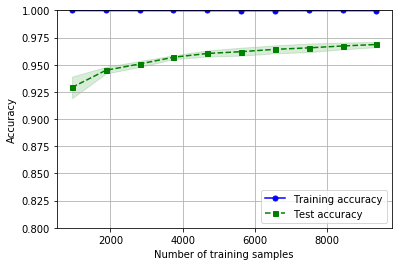

In [28]:
# Produce the necessary data for a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=crf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=3,
                                                        verbose=1,
                                                        n_jobs=-1)

# Find the means and standard deviations of the training and test datasets across the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std)